# Food Delivery Operations Exploratory Data Analysis

In [1]:
# Importing Dataset from Kaggle

import kagglehub
Zomato_dataset = kagglehub.dataset_download('saurabhbadole/zomato-delivery-operations-analytics-dataset')

print('Data source import complete.')

Data source import complete.


In [2]:
!pip install geopy
!pip install haversine
!pip install folium

In [3]:
# Importing all the required libraries

import numpy as np
import pandas as pd
import os
import gc
from datetime import datetime
from datetime import date as dt
import geopy.distance
import gmplot

import warnings
warnings.simplefilter(action='ignore')

#Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sborn

#Geo coding libraries
from haversine import haversine, Unit
from sklearn.cluster import DBSCAN
import json
from geopy.geocoders import Nominatim
import time

#variables
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
TIME_FORMAT = '%H:%M'
DATE_FORMAT = '%d-%m-%Y'

In [4]:
# helper function/s

# calculate time difference
def get_timediff(t1:str, t2:str):
    
    '''
    get time difference between 2 time strings
    note: assumption is that t2 is always greater !
    '''
    try:
        t1 = datetime.strptime(t1, TIME_FORMAT)
        t2 = datetime.strptime(t2, TIME_FORMAT)
        if t2 > t1:
            subtractedTime = t2 - t1
            return int(subtractedTime.total_seconds() / 60)  # conver to mins
        else:
            return None
    except:
        return None
    

# calculate distance from geo-coordinates
def get_distance(rlat:float, rlon:float, dlat:float, dlon:float):
    
    '''
    get the distance (km) between 2 geo - coordinates
    note: the argument order does not change (restaurant > delivert loc.)
    '''
    # restaurant co-ordinates
    res_coords = (abs(rlat), abs(rlon))
    
    # delivery location co-ordinates
    dl_coords = (abs(dlat), abs(dlon))
    
    # get the distance
    try:
        dist = geopy.distance.geodesic(res_coords, dl_coords).km
        return round(dist,2)             # round to nearest 2 decimals
    except:
        return None

In [5]:
#import csv file as a pandas data frame along with date parsing for Order_date (optimization)

csv_file_path = os.path.join(Zomato_dataset, 'Zomato Dataset.csv')
dateparse = lambda x: datetime.strptime(x, DATE_FORMAT)
df = pd.read_csv(csv_file_path, parse_dates=['Order_Date'], date_parser=dateparse)

#drop rows with null values
df.dropna(inplace=True)

# renaming columns with spaces (to avoid data type errors)
df.rename(columns={'Time_taken (min)':'Time_taken_min'}, inplace=True)

# formatting column names -- optional
df.columns = [c.lower() for c in df.columns]
          
# sorting data for visualization
df.sort_values(by=['order_date'],inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,id,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_min
0,0xc102,KOLRES19DEL02,27.0,4.4,-22.549100,88.400467,22.569100,88.420467,2022-02-11,11:55,12:10,Sunny,High,0,Snack,motorcycle,2.0,No,Metropolitian,49
1,0xc47e,ALHRES07DEL01,22.0,4.1,25.449659,81.839744,25.459659,81.849744,2022-02-11,09:45,09:50,Windy,Low,0,Meal,motorcycle,0.0,No,Metropolitian,16
2,0xcff9,AURGRES13DEL02,24.0,5.0,19.880256,75.323503,19.930256,75.373503,2022-02-11,17:45,17:50,Cloudy,Medium,1,Buffet,motorcycle,1.0,No,Metropolitian,15
3,0xdef0,AURGRES12DEL01,34.0,4.8,19.879631,75.323403,19.919631,75.363403,2022-02-11,16:15,16:20,Windy,Medium,1,Snack,motorcycle,1.0,No,Metropolitian,34
4,0xbfcc,LUDHRES010DEL01,29.0,4.7,30.892860,75.822199,30.932860,75.862199,2022-02-11,15:40,15:50,Fog,Medium,2,Drinks,electric_scooter,0.0,No,Metropolitian,17


In [6]:
# de-duplication criteria#1 columns 
dup_c1 = ['delivery_person_id'
       ,'delivery_person_age'
       #,'delivery_location_latitude'
       #,'delivery_location_longitude'
       ,'order_date'
       ,'time_orderd']

# de-duplicate the dataset (keep = None)
df = df[~df.duplicated(subset=dup_c1, keep=False)]

### convert age into INT ###  -- optional
df['delivery_person_age'] = df['delivery_person_age'].astype(np.int64)

### derive pickup time(mins) = time_ordered - time_order_picked ###
time_diff = []

for idx, row in df.iterrows():
    td = get_timediff(row['time_orderd'],row['time_order_picked'])
    time_diff.append(td)

df['pickup_time_min'] = time_diff
df = df[~df['pickup_time_min'].isnull()]
df['pickup_time_min'] = df['pickup_time_min'].astype(np.int64)

print(f"Data Shape: {df.shape}\n\n")

Data Shape: (33393, 21)




# Visualizing restaurant locations and data clustering

In [7]:
# Step 1: Create a unique DataFrame of restaurant locations
unique_restaurants = df[['restaurant_latitude', 'restaurant_longitude']].drop_duplicates().reset_index(drop=True)

# Step 2: Assign a unique ID
unique_restaurants['restaurant_id'] = range(1, len(unique_restaurants) + 1)

# Step 3: Merge back to original DataFrame
df = df.merge(unique_restaurants, on=['restaurant_latitude', 'restaurant_longitude'], how='left')

df.info()

# Group by restaurant_id and count number of orders
df1 = df.groupby(['restaurant_id', 'restaurant_latitude', 'restaurant_longitude']).agg(
    total_orders=('restaurant_id', 'count')
).reset_index()

# All restaurants in Mumbai
df2 = df1[(df1['restaurant_latitude'] >= 10)].reset_index(drop=True)

# Preview
print(df2.head())
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33393 entries, 0 to 33392
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           33393 non-null  object        
 1   delivery_person_id           33393 non-null  object        
 2   delivery_person_age          33393 non-null  int64         
 3   delivery_person_ratings      33393 non-null  float64       
 4   restaurant_latitude          33393 non-null  float64       
 5   restaurant_longitude         33393 non-null  float64       
 6   delivery_location_latitude   33393 non-null  float64       
 7   delivery_location_longitude  33393 non-null  float64       
 8   order_date                   33393 non-null  datetime64[ns]
 9   time_orderd                  33393 non-null  object        
 10  time_order_picked            33393 non-null  object        
 11  weather_conditions           33393 non-nu

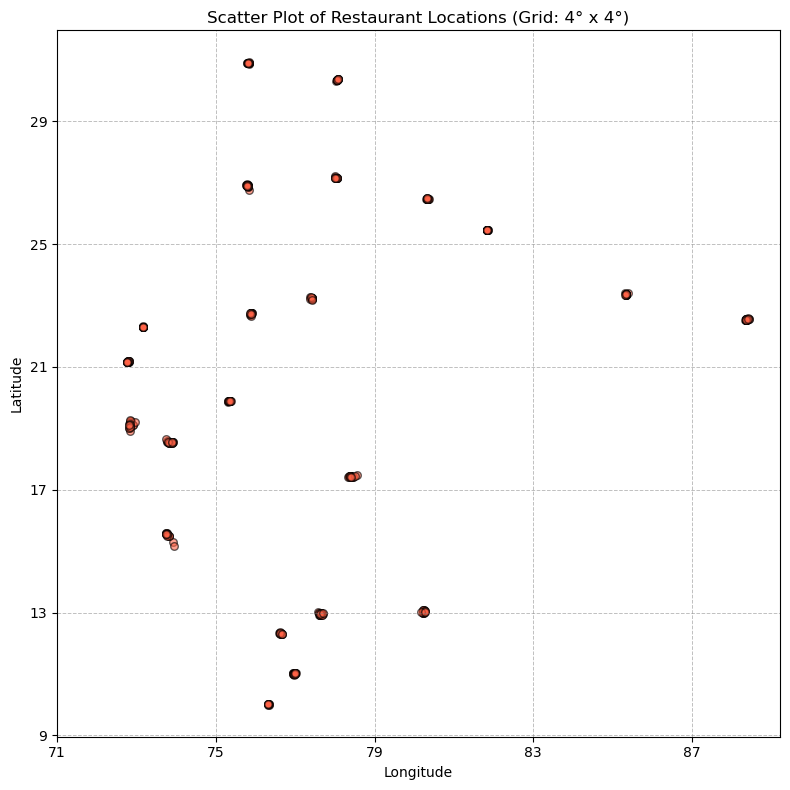

In [8]:
# Create the figure
plt.figure(figsize=(8, 8))

# Scatter plot of restaurant locations
plt.scatter(df2['restaurant_longitude'], df2['restaurant_latitude'],
            alpha=0.6, edgecolor='black', color='tomato', s=30)

# Set axis labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Restaurant Locations (Grid: 4° x 4°)')

# Define grid spacing
lon_min, lon_max = df2['restaurant_longitude'].min(), df2['restaurant_longitude'].max()
lat_min, lat_max = df2['restaurant_latitude'].min(), df2['restaurant_latitude'].max()

# Set ticks for every 4 degrees
plt.xticks(range(int(lon_min)-1, int(lon_max)+2, 4))
plt.yticks(range(int(lat_min)-1, int(lat_max)+2, 4))

# Add vertical and horizontal gridlines at every 4 degrees
for x in range(int(lon_min)-1, int(lon_max)+2, 4):
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.7, alpha=0.5)
for y in range(int(lat_min)-1, int(lat_max)+2, 4):
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.7, alpha=0.5)

# Add custom grid
plt.grid(False)
plt.tight_layout()
plt.show()


In [9]:
# Load your dataset
coords = df2[['restaurant_latitude', 'restaurant_longitude']].values

# Haversine distance function returns distance in kilometers
def haversine_distance_matrix(locations):
    n = len(locations)
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            matrix[i, j] = haversine(locations[i], locations[j], unit=Unit.KILOMETERS)
    return matrix

# Step 1: Convert lat/lon to radians for DBSCAN with haversine
coords_radians = np.radians(coords)

# Step 2: Run DBSCAN clustering
# 30 km radius city ⇒ epsilon = 30 km (converted to radians)
kms_per_radian = 6371.0088
epsilon = 30 / kms_per_radian  # radius in radians

db = DBSCAN(eps=epsilon, min_samples=5, algorithm='ball_tree', metric='haversine').fit(coords_radians)
df2['city_label'] = db.labels_  # -1 means noise

# Step 3: Preview city-labeled data
print(df2[['restaurant_latitude', 'restaurant_longitude', 'city_label']].head())

# Optional: Save labeled data
df2.to_csv("zomato_with_city_labels.csv", index=False)


   restaurant_latitude  restaurant_longitude  city_label
0            25.449659             81.839744           0
1            19.880256             75.323503           1
2            19.879631             75.323403           1
3            30.892860             75.822199           2
4            22.538999             88.322337           3


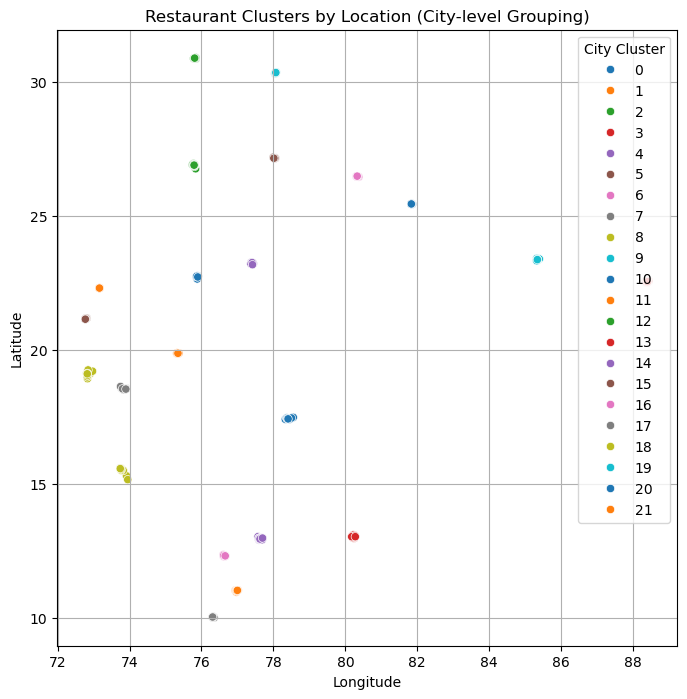

In [10]:
# Basic scatter plot with clusters
plt.figure(figsize=(8, 8))
sborn.scatterplot(
    data=df2,
    x='restaurant_longitude',
    y='restaurant_latitude',
    hue='city_label',
    palette='tab10',
    legend='full'
)
plt.title("Restaurant Clusters by Location (City-level Grouping)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title='City Cluster')
plt.grid(True)
plt.show()


In [11]:
# Load or initialize cache
if os.path.exists("geocoding_cache.json"):
    with open("geocoding_cache.json", "r") as f:
        geocoding_cache = json.load(f)
else:
    geocoding_cache = {}

# Compute cluster centers using median
cluster_centers = df2.groupby('city_label')[['restaurant_latitude', 'restaurant_longitude']].median().reset_index()

# Initialize geolocator
geolocator = Nominatim(user_agent="geoapi")

def fun_coord_key(lat, lon):
    return f"{round(lat, 5)},{round(lon, 5)}"

def get_city_name_with_fallback(cluster_label, lat, lon, df_clustered):
    key = fun_coord_key(lat, lon)
    
    # Return from cache if available
    if key in geocoding_cache:
        print(f"[CACHE HIT] {key} → {geocoding_cache[key]}")
        return geocoding_cache[key]
    
    print(f"[CACHE MISS] {key} → making API call...")
    
    # Try reverse geocoding on center
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True, timeout=10)
        if location and 'address' in location.raw:
            city = location.raw['address'].get('city') or \
                   location.raw['address'].get('town') or \
                   location.raw['address'].get('state')
            if city:
                geocoding_cache[key] = city
                return city
    except Exception as e:
        print(f"[ERROR] Reverse geocoding failed for center: {e}")
    
    # Fallback: iterate through other coordinates in the cluster
    group = df_clustered[df_clustered['city_label'] == cluster_label]
    for _, row in group.iterrows():
        coord_key = fun_coord_key(row['restaurant_latitude'], row['restaurant_longitude'])
        if coord_key in geocoding_cache:
            return geocoding_cache[coord_key]
        try:
            location = geolocator.reverse(
                (row['restaurant_latitude'], row['restaurant_longitude']),
                exactly_one=True,
                timeout=10
            )
            if location and 'address' in location.raw:
                city = location.raw['address'].get('city') or \
                       location.raw['address'].get('town')
                if city:
                    geocoding_cache[coord_key] = city
                    return city
        except Exception as e:
            print(f"[FALLBACK ERROR] {coord_key}: {e}")
        time.sleep(1)  # Respect API limits
    
    geocoding_cache[key] = "Unknown"
    return "Unknown"

# Apply the function to cluster centers
cluster_centers['city_name'] = cluster_centers.apply(
    lambda row: get_city_name_with_fallback(
        cluster_label=row['city_label'],
        lat=row['restaurant_latitude'],
        lon=row['restaurant_longitude'],
        df_clustered=df2
    ),
    axis=1
)

with open("geocoding_cache.json", "w") as f:
    json.dump(geocoding_cache, f, indent=2)

# Drop city_name if it exists in df2
if 'city_name' in df2.columns:
    df2 = df2.drop(columns=['city_name'])

# Then merge
df2 = df2.merge(
    cluster_centers[['city_label', 'city_name']],
    on='city_label',
    how='left'
)

[CACHE HIT] 25.45165,81.8345 → Prayagraj
[CACHE HIT] 19.87601,75.3434 → Chhatrapati Sambhaji Nagar
[CACHE HIT] 30.89324,75.82183 → Ludhiana
[CACHE HIT] 22.53906,88.36519 → Kolkata
[CACHE HIT] 23.23245,77.42462 → Bhopal
[CACHE HIT] 27.16168,78.03744 → Agra
[CACHE HIT] 26.47637,80.32082 → Kanpur
[CACHE HIT] 10.02385,76.31033 → Ernakulam
[CACHE HIT] 15.54442,73.76667 → Calangute
[CACHE HIT] 30.34251,78.06119 → Dehradun
[CACHE HIT] 17.43157,78.39911 → Hyderabad
[CACHE HIT] 22.31094,73.16777 → Vadodara
[CACHE HIT] 26.90524,75.79594 → Jaipur
[CACHE HIT] 13.03724,80.24235 → Chennai
[CACHE HIT] 12.96008,77.63324 → Bengaluru
[CACHE HIT] 21.17093,72.78989 → Gujarat
[CACHE HIT] 12.32319,76.62796 → Mysuru
[CACHE HIT] 18.54494,73.84048 → Pune City
[CACHE HIT] 19.12104,72.83435 → Mumbai Suburban
[CACHE HIT] 23.35911,85.32559 → Ranchi
[CACHE HIT] 22.74529,75.88857 → Indore
[CACHE HIT] 11.00951,76.97638 → Coimbatore


In [12]:
print(f"Loaded {len(geocoding_cache)} cached coordinates.")

Loaded 24 cached coordinates.


In [13]:
import folium

# Step 1: Cluster summary
cluster_stats = df2.groupby('city_name').agg({
    'restaurant_latitude': 'median',
    'restaurant_longitude': 'median',
    'restaurant_id': pd.Series.nunique
}).reset_index().rename(columns={'restaurant_id': 'restaurant_count'})

# Step 2: Base map centered over India
fmap = folium.Map(
    location=[
        cluster_stats['restaurant_latitude'].mean(),
        cluster_stats['restaurant_longitude'].mean()
    ],
    zoom_start=5,
    tiles='CartoDB Positron'  # Cleaner look
)

# Step 3: Plot circles
for _, row in cluster_stats.iterrows():
    lat = row['restaurant_latitude']
    lon = row['restaurant_longitude']
    city = row['city_name']
    count = row['restaurant_count']

    radius = 12000 * np.sqrt(count)
    font_size = min(108, 10 + int(np.sqrt(count)))  # Cap max size for clarity

    # Circle for the cluster
    folium.Circle(
        location=[lat, lon],
        radius=radius,
        color='Green',
        fill=True,
        fill_opacity=0.4
    ).add_to(fmap)

    # Label: restaurant count (center of circle)
    folium.Marker(
        location=[lat, lon],
        icon=folium.DivIcon(html=f"""
            <div style="text-align: center;">
                <span style="
                    font-size: {font_size}px;
                    font-weight: bold;
                    color: black;
                    line-height: 1;
                ">{count}</span>
            </div>
        """)
    ).add_to(fmap)

    # Label: city name (below circle)
    folium.Marker(
        location=[lat - 0.1 * np.sqrt(count), lon],  # shift slightly downward (tweak 0.2 as needed)
        icon=folium.DivIcon(html=f"""
            <div style="text-align: center;">
                <span style="
                    font-size: {font_size - 2}px;
                    font-weight: normal;
                    color: grey;
                ">{city}</span>
            </div>
        """)
    ).add_to(fmap)



# Step 4: Save or display
fmap.save("zomato_clusters_folium.html")

# If in notebook:
from IPython.display import IFrame
IFrame("zomato_clusters_folium.html", width=900, height=600)


# Pattern analysis

In [14]:
### Cleaning up utilized columns in order to keep data table limited
unwanted_cols = ['time_orderd','time_order_picked']
df.drop(unwanted_cols, inplace=True, axis=1)

### derive distance between restaurant & delivery location ###
dist = []

for idx, row in df.iterrows():
    d = get_distance(row['restaurant_latitude'], row['restaurant_longitude'], row['delivery_location_latitude'], row['delivery_location_longitude'])
    dist.append(d)
    
df['delivery_dist_km'] = dist

unwanted_cols = ['restaurant_latitude','restaurant_longitude', 'delivery_location_latitude', 'delivery_location_longitude']
df.drop(unwanted_cols, inplace=True, axis=1)

df.reset_index(drop=True, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33393 entries, 0 to 33392
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       33393 non-null  object        
 1   delivery_person_id       33393 non-null  object        
 2   delivery_person_age      33393 non-null  int64         
 3   delivery_person_ratings  33393 non-null  float64       
 4   order_date               33393 non-null  datetime64[ns]
 5   weather_conditions       33393 non-null  object        
 6   road_traffic_density     33393 non-null  object        
 7   vehicle_condition        33393 non-null  int64         
 8   type_of_order            33393 non-null  object        
 9   type_of_vehicle          33393 non-null  object        
 10  multiple_deliveries      33393 non-null  float64       
 11  festival                 33393 non-null  object        
 12  city                     33393 n

In [25]:
rating_variation = df.groupby('delivery_person_id')['delivery_person_ratings'].nunique()

# Find delivery persons with more than one unique rating
inconsistent_ratings = rating_variation[rating_variation > 1]

print(f"Number of delivery persons with varying ratings: {len(inconsistent_ratings)}")

consistent_ratings = rating_variation[rating_variation == 1]
print(f"Number of delivery persons with same ratings: {len(consistent_ratings)}")

# renaming the delivery_person_ratings column appropriately
df.rename(columns={'delivery_person_ratings': 'delivery_satisfaction_rating'}, inplace=True)


Number of delivery persons with varying ratings: 1320
Number of delivery persons with same ratings: 0


In [19]:
df2.head()

,restaurant_id,restaurant_latitude,restaurant_longitude,total_orders,city_label,city_name
0,2,25.449659,81.839744,38,0,Prayagraj
1,3,19.880256,75.323503,24,1,Chhatrapati Sambhaji Nagar
2,4,19.879631,75.323403,26,1,Chhatrapati Sambhaji Nagar
3,5,30.892860,75.822199,26,2,Ludhiana
4,6,22.538999,88.322337,24,3,Kolkata
